# "LightGBM on GPU with Feature Engineering, Optuna, and , Visualization"
1. Author: [@Satoru Shibata/柴田 怜](https://www.kaggle.com/satorushibata)
1. The original author: [@tito](https://www.kaggle.com/its7171)
  - I forked and edited [whose Notebook](https://www.kaggle.com/its7171/lgbm-with-loop-feature-engineering).

# Abstract:
1. [Riiid! Answer Correctness Prediction](https://www.kaggle.com/c/riiid-test-answer-prediction/overview)
1. This is a Code Competition
1. So, make the best model here and submit [this Kernel](https://www.kaggle.com/satorushibata/lgbm-with-loop-feature-engineering-optuna-plot)
1. I thank the original author, [@tito](https://www.kaggle.com/its7171).

# Use Google Colaboratory(GPU & 20GB) with Kaggle API:

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive')

In [3]:
!pip install -q kaggle --upgrade
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# I need to set permissions
!chmod 600 ~/.kaggle/kaggle.json
# Find the competition name.
!kaggle competitions list

kaggle.json
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         84            True  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        183           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        273           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2145            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      16970            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4518            Tru

# Maximize the memory of Python3:

In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 113.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# Preparation for parallel process:
1. Check the number of CPU cores;
1. [Reference](https://qiita.com/taka-kawa/items/d1fc1bc0acb3a6ca3031#%E4%B8%A6%E5%88%97%E5%87%A6%E7%90%86%E3%81%A8%E5%8D%98%E7%B4%94%E5%AE%9F%E8%A3%85%E3%81%AE%E5%AE%9F%E8%A1%8C%E6%99%82%E9%96%93%E6%AF%94%E8%BC%83)

In [5]:
# Check the number of CPU cores.
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

# Prepare the prerequisites:
## It works only for the first time.
### Reference:
- [Setting LightGBM with GPU on Google Colabratory](https://stackoverflow.com/questions/58707252/get-lightgbm-lgbm-run-with-gpu-on-google-colabratory)
- [Install LightGBM(BUILD GPU VERSION)](https://pypi.org/project/lightgbm/)

In [6]:
"""
!pip install gc
!pip install sklearn
!pip install collections
!pip install tqdm
!pip install optuna
!pip install matplotlib
# To use GPU on LightGBM
!pip install lightgbm --install-option=--gpu
!git clone --recursive https://github.com/Microsoft/LightGBM
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
"""

'\n!pip install gc\n!pip install sklearn\n!pip install collections\n!pip install tqdm\n!pip install optuna\n!pip install matplotlib\n# To use GPU on LightGBM\n!pip install lightgbm --install-option=--gpu\n!git clone --recursive https://github.com/Microsoft/LightGBM\n!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;\n'

# Prepare to apply GPU to LightGBM:
## Reference:
- [GoogleColabratory + GradientBoosting + GPU](https://qiita.com/wakame1367/items/bcf8b760260329fb7136)

In [7]:
"""
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile
"""

'\n!git clone --recursive https://github.com/Microsoft/LightGBM\n%cd /content/LightGBM/\n!mkdir build\n!cmake -DUSE_GPU=1 #avoid ..\n!make -j$(nproc)\n!sudo apt-get -y install python-pip\n!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U\n%cd /content/LightGBM/python-package\n!sudo python setup.py install --precompile\n'

# Run the Notebook referring to Kernel of Kaggle:
1. I created this file based on [this notebook](https://www.kaggle.com/its7171/lgbm-with-loop-feature-engineering);
1. And I am grateful for [the author, @tito](https://www.kaggle.com/its7171).

In [8]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
# Automate hyperparameter tuning for LightGBM
import optuna
import lightgbm as lgb
# Plot
import matplotlib.pyplot as plt
# Save
import pickle
from multiprocessing import Pool

In [9]:
# Make sure this notebook has completed to import LightGBM
print(lgb.__version__)

3.1.1.99


## Setting:
CV files are generated by [this notebook](https://www.kaggle.com/its7171/cv-strategy)

In [10]:
train_pickle = 'cv1_train.pickle'
valid_pickle = 'cv1_valid.pickle'
question_file = 'questions.csv'
# Initial conditions:
debug = False        # It were True, I have confirmed that AUC of validation is reduced.
validaten_flg = False

## Feature Engineering:

In [11]:
# funcs for user stats with loop
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def add_user_feats_without_update(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(df[['user_id']].values):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def update_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    for row in df[['user_id','answered_correctly','content_type_id']].values:
        if row[2] == 0:
            answered_correctly_sum_u_dict[row[0]] += row[1]
            count_u_dict[row[0]] += 1

In [12]:
# read data
feld_needed = ['row_id', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train = pd.read_pickle(train_pickle)[feld_needed]
valid = pd.read_pickle(valid_pickle)[feld_needed]
if debug:
    train = train[:1000000]
    valid = valid[:10000]
train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

# answered correctly average for each content
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c']
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

# user stats features with loops
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict)

# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# part
questions_df = pd.read_csv(question_file)
train = pd.merge(train, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

## Modeling:

In [13]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time']
dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [14]:
lgb_train = lgb.Dataset(train[FEATS], y_tr)
lgb_valid = lgb.Dataset(valid[FEATS], y_va, reference = lgb_train)
del train, y_tr
_=gc.collect()

## Tuning with Optuna:
### Reference:
- [Optuna/README.md](https://github.com/optuna/optuna/blob/master/README.md)
- [GPU acceleration for LightGBM](https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/)
- [verbose_eval](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html)
- [Potting on LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html)
- [lgb.plot_split_value_histogram](https://www.kaggle.com/madiyar/ieee-fraud-lightgbm-split-value-histogram)
- [lgb.plot_metric](https://www.kaggle.com/tobikaggle/humble-lightgbm-starter-with-learning-curve)
- [lgb.plot_tree](https://www.kaggle.com/maria591/lightgbm)
- [lgb.create_tree_digraph](https://www.programmersought.com/article/794564372/)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
- [evals_result](https://hk29.hatenablog.jp/entry/2019/12/31/172437)
- [Debug](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/88681)
- [Bootstrap sampling](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.utils.resample.html)

In [15]:
# Make the model of LightGBM and plots it's results.
def LightGBM(params, lgb_train, lgb_valid, num_boost_round, verbose_eval, FEATS):
  # To record evaluation results for plotting
  evaluation_result = {}
  # Training
  model = lgb.train(params,
                    lgb_train,
                    valid_sets = [lgb_train, lgb_valid],
                    num_boost_round = int(num_boost_round),
                    verbose_eval = int(verbose_eval),
                    evals_result = evaluation_result
                    )
  # Plots
  lgb.plot_importance(model)
  plt.show()
  for feature in FEATS:
    lgb.plot_split_value_histogram(model, feature=feature)
    plt.show()
  lgb.plot_metric(evaluation_result, metric='auc')
  plt.show()
  lgb.plot_tree(model, figsize=(30, 50))
  plt.show()
  lgb.create_tree_digraph(model, tree_index=int(20), name='Tree digraph')
  plt.show()
  # The result
  return model

In [16]:
# Initial conditions of LightGBM:
num_boost_round = 300
verbose_eval = 30

In [17]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'AUC',
        'boosting_type': 'dart', # To improve AUC
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 0.9),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }
    # Learning
    gbm = LightGBM(params, lgb_train, lgb_valid, num_boost_round, verbose_eval, FEATS)
    # Prediction
    accuracy = roc_auc_score(y_va, gbm.predict(valid[FEATS]), labels='ROC curve', average='weighted', multi_class='raise')
    print('ROC curve:', accuracy)
    # Finish
    print("Operation completed.")
    # Output
    return accuracy

## Run the functions:
### Reference:
- [optuna.study](https://optuna.readthedocs.io/en/stable/reference/study.html)
- [最適なパラメータを効率的に探索しちゃおっちゅうな(Optuna)](https://qiita.com/maskot1977/items/ed698a67b091b5516ab4#lightgbm--optuna)
- [プロセッサのコアの数を確認する](https://support.microsoft.com/ja-jp/windows/%E3%83%97%E3%83%AD%E3%82%BB%E3%83%83%E3%82%B5%E3%81%AE%E3%82%B3%E3%82%A2%E3%81%AE%E6%95%B0%E3%82%92%E7%A2%BA%E8%AA%8D%E3%81%99%E3%82%8B-3126ef99-0247-33b3-81fc-065e9fb0c35b)

[I 2020-12-21 12:33:02,918] A new study created in memory with name: no-name-b9205e4e-7d14-45d9-8a49-c5111c9cccfd


[30]	training's auc: 0.748221	valid_1's auc: 0.757373
[60]	training's auc: 0.749754	valid_1's auc: 0.759133
[90]	training's auc: 0.750011	valid_1's auc: 0.759628
[120]	training's auc: 0.750012	valid_1's auc: 0.759284
[150]	training's auc: 0.750447	valid_1's auc: 0.760115
[180]	training's auc: 0.750546	valid_1's auc: 0.760647
[210]	training's auc: 0.750867	valid_1's auc: 0.760835
[240]	training's auc: 0.751047	valid_1's auc: 0.760784
[270]	training's auc: 0.751211	valid_1's auc: 0.760803
[300]	training's auc: 0.751435	valid_1's auc: 0.761076


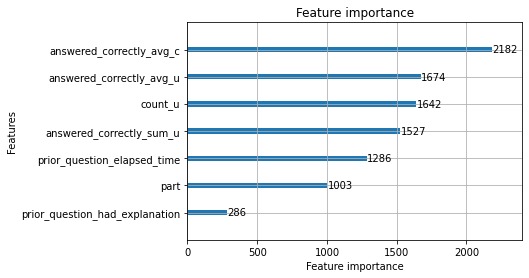

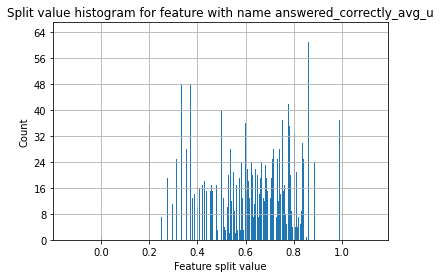

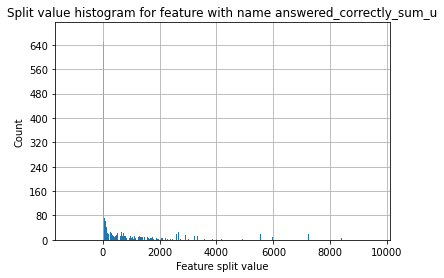

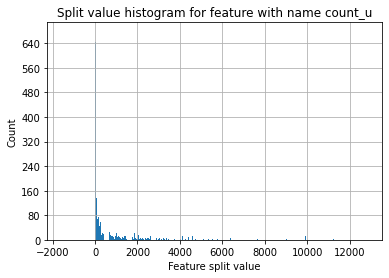

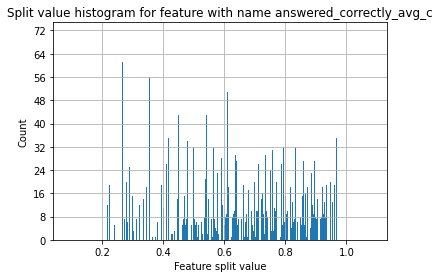

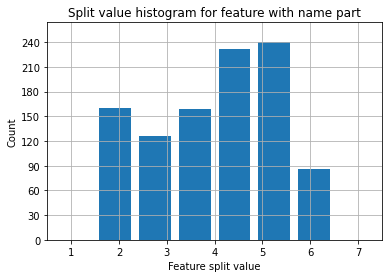

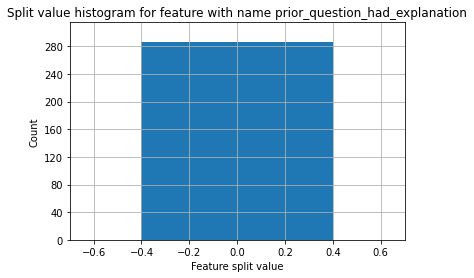

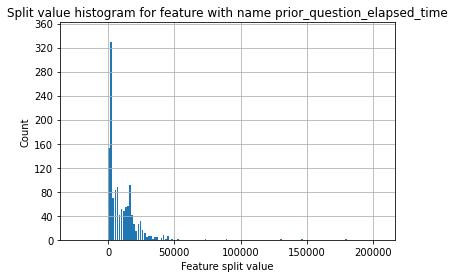

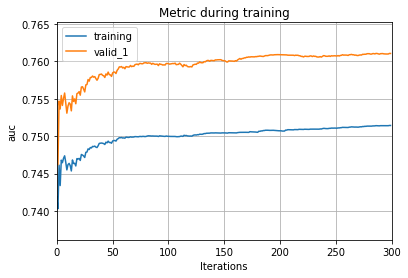

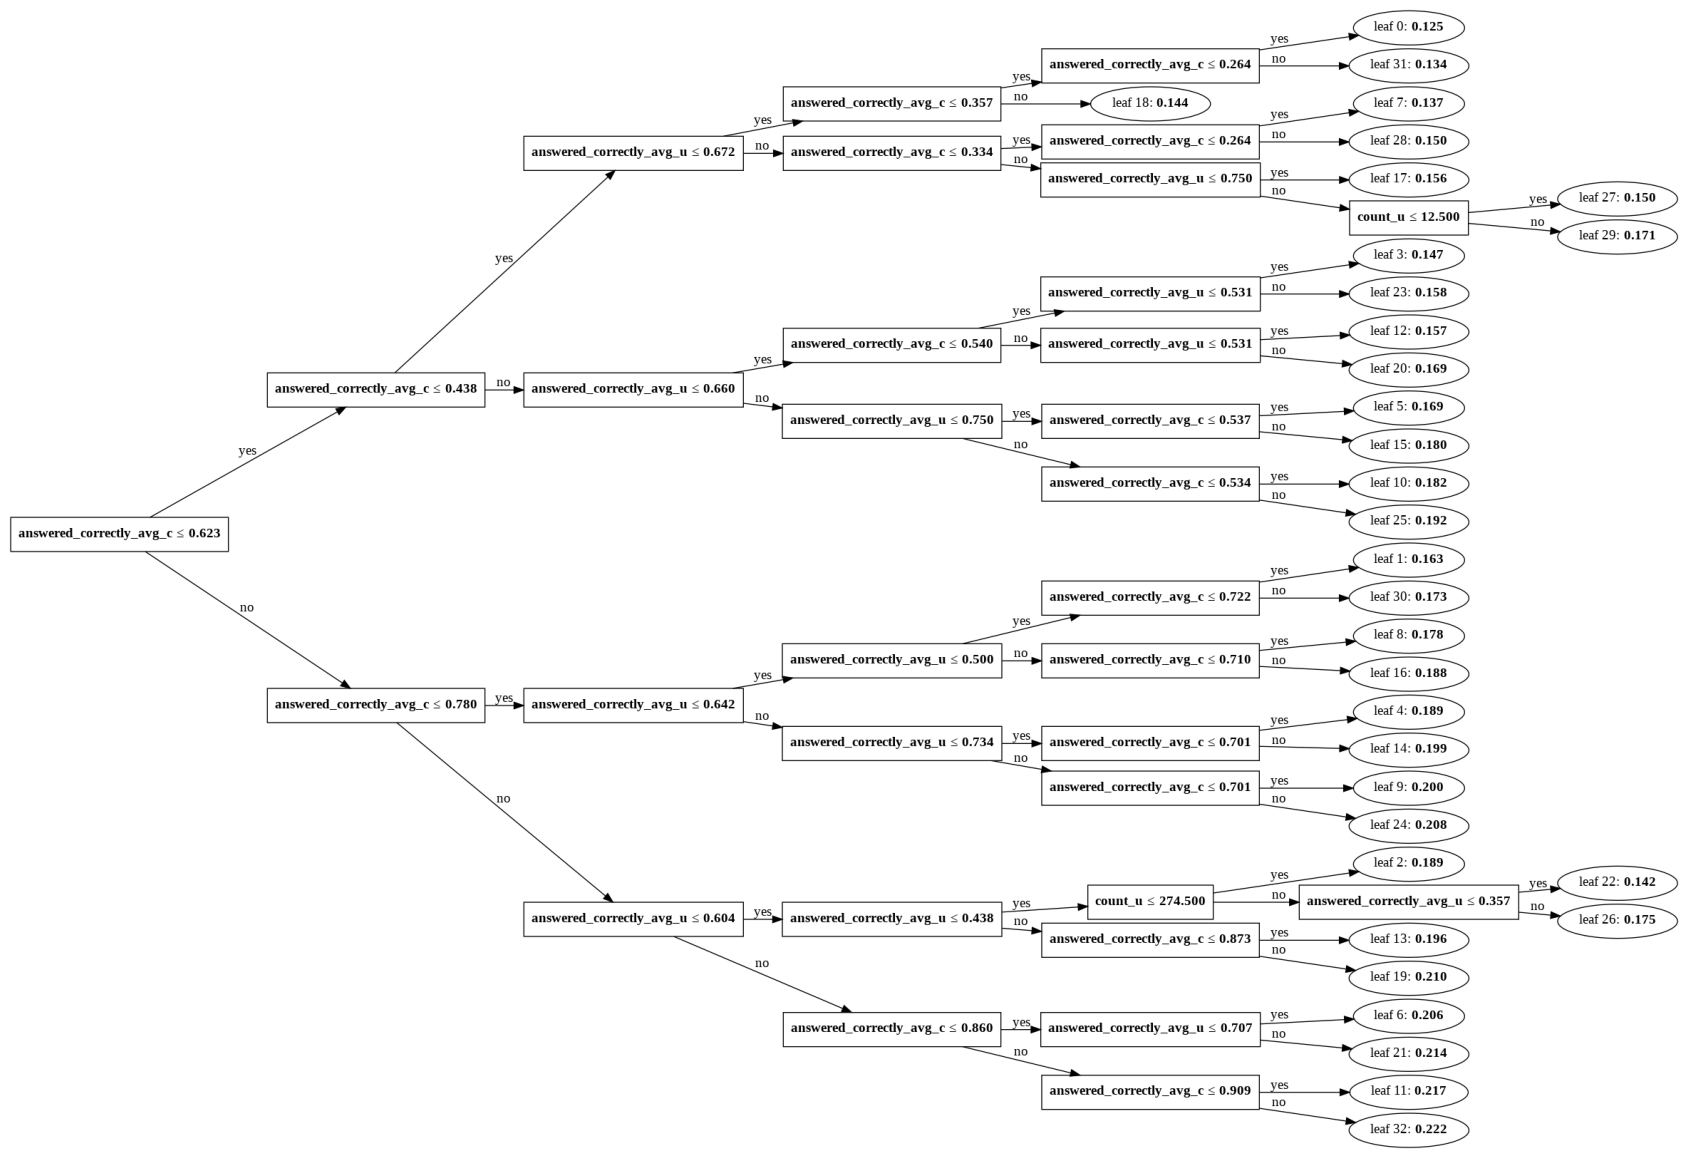

[I 2020-12-21 13:16:49,794] Trial 0 finished with value: 0.7610496244488411 and parameters: {'lambda_l1': 0.11438196901237276, 'lambda_l2': 0.44167065682241313, 'num_leaves': 33, 'feature_fraction': 0.4286499111129028, 'bagging_fraction': 0.8650204850463731, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 0 with value: 0.7610496244488411.


ROC curve: 0.7610496244488411
Operation completed.


In [18]:
with Pool(processes = int(6)) as pool:
  study = optuna.create_study(direction = 'maximize')
  study.optimize(objective, n_trials = int(1), n_jobs = int(6))

## Results of LightGBM at such simulation:
### Print and confirm.

In [19]:
# print('Number of finished trials:', len(study.trials))
print('The best of trials:', study.best_trial.params)

The best of trials: {'lambda_l1': 0.11438196901237276, 'lambda_l2': 0.44167065682241313, 'num_leaves': 33, 'feature_fraction': 0.4286499111129028, 'bagging_fraction': 0.8650204850463731, 'bagging_freq': 1, 'min_child_samples': 98}


In [20]:
"""
plt.plot([trial.value for trial in study.trials], label = 'Value')
plt.grid()
plt.legend()
plt.show()
"""

"\nplt.plot([trial.value for trial in study.trials], label = 'Value')\nplt.grid()\nplt.legend()\nplt.show()\n"

### The best model of LightGBM to train and validate:
1. Write .pickle about the best of all parameters;
1. Write the model.pickle to Kernel notebook of Kaggle.
  - [Reference](https://blog.amedama.jp/entry/2018/05/08/033909)

In [21]:
params = {
        'objective': 'binary',
        'metric': 'AUC',
        'boosting_type': 'dart'
}
params.update(study.best_trial.params)
print(params)
pickle.dump(params, open('The_best_of_all_parameters_on_LightGBM.pickle', 'wb'))

{'objective': 'binary', 'metric': 'AUC', 'boosting_type': 'dart', 'lambda_l1': 0.11438196901237276, 'lambda_l2': 0.44167065682241313, 'num_leaves': 33, 'feature_fraction': 0.4286499111129028, 'bagging_fraction': 0.8650204850463731, 'bagging_freq': 1, 'min_child_samples': 98}


# The best of LightGBM:

[LightGBM] [Info] Number of positive: 6296107, number of negative: 3262912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.596496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 9559019, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.658656 -> initscore=0.657311
[LightGBM] [Info] Start training from score 0.657311
[30]	training's auc: 0.748221	valid_1's auc: 0.757373
[60]	training's auc: 0.749754	valid_1's auc: 0.759133
[90]	training's auc: 0.750011	valid_1's auc: 0.759628
[120]	training's auc: 0.750012	valid_1's auc: 0.759284
[150]	training's auc: 0.750447	valid_1's auc: 0.760115
[180]	training's auc: 0.750546	valid_1's auc: 0.760647
[210]	training's auc: 0.750867	valid_1's auc: 0.760835
[240]	training's auc: 0.751047	valid_1's auc: 0.760784
[270]	training's auc: 0.751211	valid_1's auc: 0.760803
[300]	tr

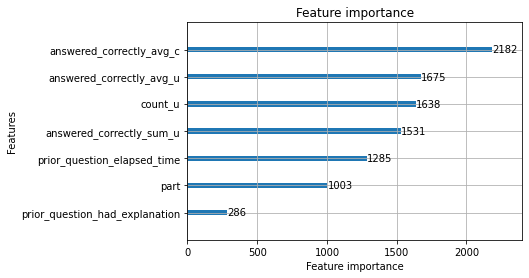

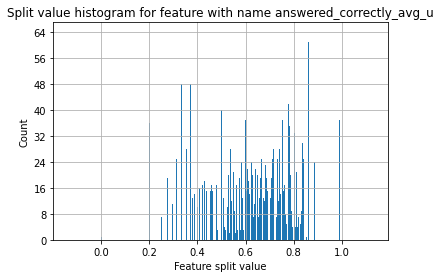

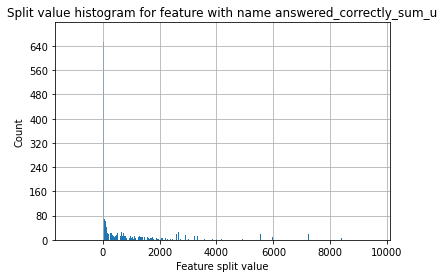

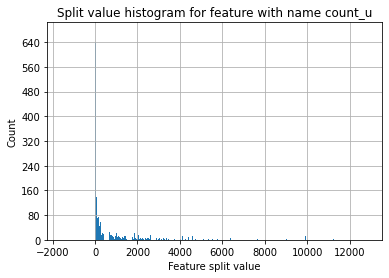

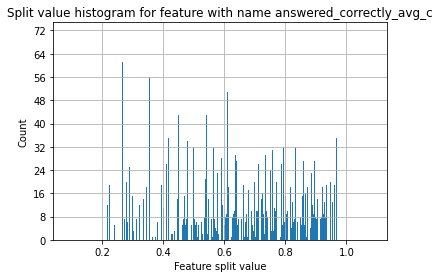

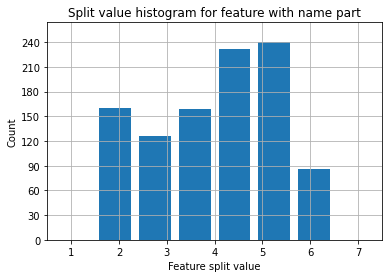

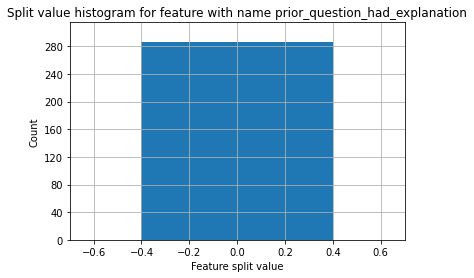

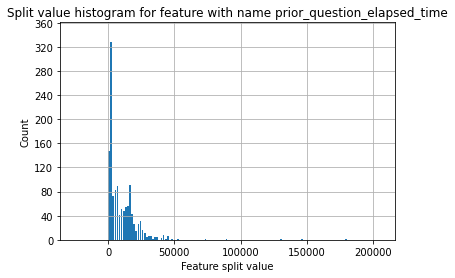

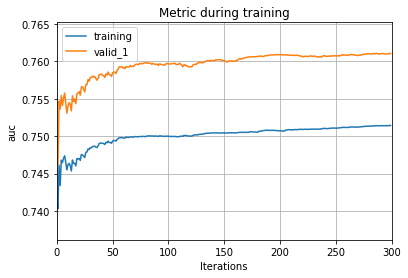

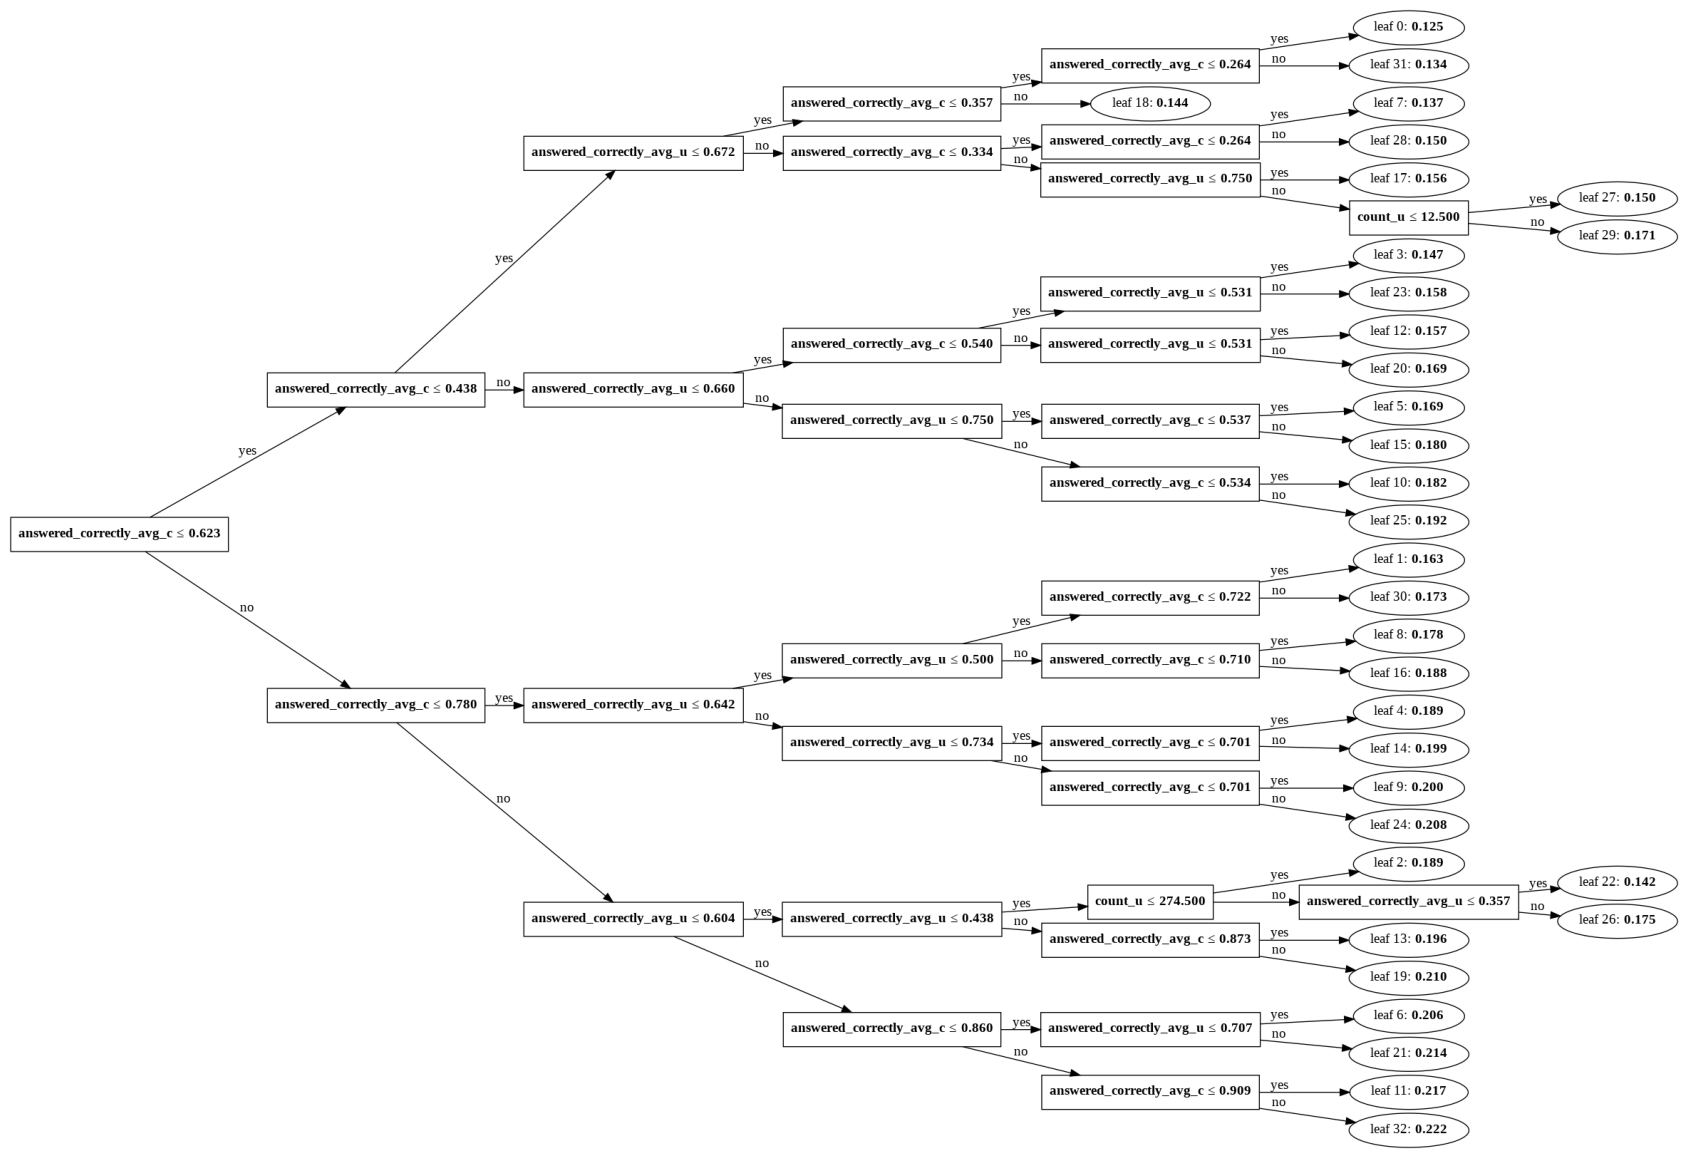

In [22]:
model = LightGBM(params, lgb_train, lgb_valid, num_boost_round, verbose_eval, FEATS)

In [23]:
pickle.dump(model, open('The_best_of_model_on_LightGBM.pickle', 'wb'))

# Pointing out by [@tito](https://www.kaggle.com/its7171)
1. You can debug your inference code to reduce "Submission Scoring Error" with `validaten_flg = True`.
1. Please refer [Time-series API (iter_test) Emulator](https://www.kaggle.com/its7171/time-series-api-iter-test-emulator) about Time-series API (iter_test) Emulator.

# Validaten
1. You would like to focus on validation;
1. Set 'would like to';
1. And run following:

In [24]:
if validaten_flg:
    target_df = pd.read_pickle(valid_pickle)
    if debug:
        target_df = target_df[:10000]
    iter_test = Iter_Valid(target_df,max_user=1000)
    predicted = []
    def set_predict(df):
        predicted.append(df)
    # reset answered_correctly_sum_u_dict and count_u_dict
    answered_correctly_sum_u_dict = defaultdict(int)
    count_u_dict = defaultdict(int)
    train = pd.read_pickle(train_pickle)[['user_id','answered_correctly','content_type_id']]
    if debug:
        train = train[:1000000]
    train = train[train.content_type_id == False].reset_index(drop=True)
    update_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
    del train

In [25]:
if validaten_flg:
  y_true = target_df[target_df.content_type_id == 0].answered_correctly
  y_pred = pd.concat(predicted).answered_correctly
  print(roc_auc_score(y_true, y_pred))
  print(roc_curve(y_true, y_pred))
  plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()